[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/08_conditional_manatees.ipynb)

# Chapter 8 - Conditional Manatees


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    
USE_NIGHTLY_TFP = True # @param
if IN_COLAB and USE_NIGHTLY_TFP:
    !pip install --upgrade tf-nightly
    !pip install --upgrade tfp-nightly

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.3
tensorflow 2.2.0-dev20200422
tensorflow_probability 0.11.0-dev20200422
arviz 0.7.0
scipy 1.4.1
pandas 1.0.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
if not USE_NIGHTLY_TFP:
    assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
    assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

## Tensorflow MCMC Sampling helpers


In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

## Dataset URLs


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

RUGGED_DATASET_PATH = f"{_BASE_URL}/rugged.csv"
TULIPS_DATASET_PATH = f"{_BASE_URL}/tulips.csv"

## Code 8.1


Every inference is conditional on something whether we notice it or not !

So far in the book, it was assumed that the predictor variable has an independent association with the mean of the outcome. What if want to allow the association to be conditional ?

In [10]:
d = pd.read_csv(RUGGED_DATASET_PATH, sep=";")

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

Note - terrain ruggedness is divided by the maximum value observed

## Code 8.2

In [11]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1., name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha + beta * (rugged_std - 0.215)
        
        log_gdp_std = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

## Code 8.3

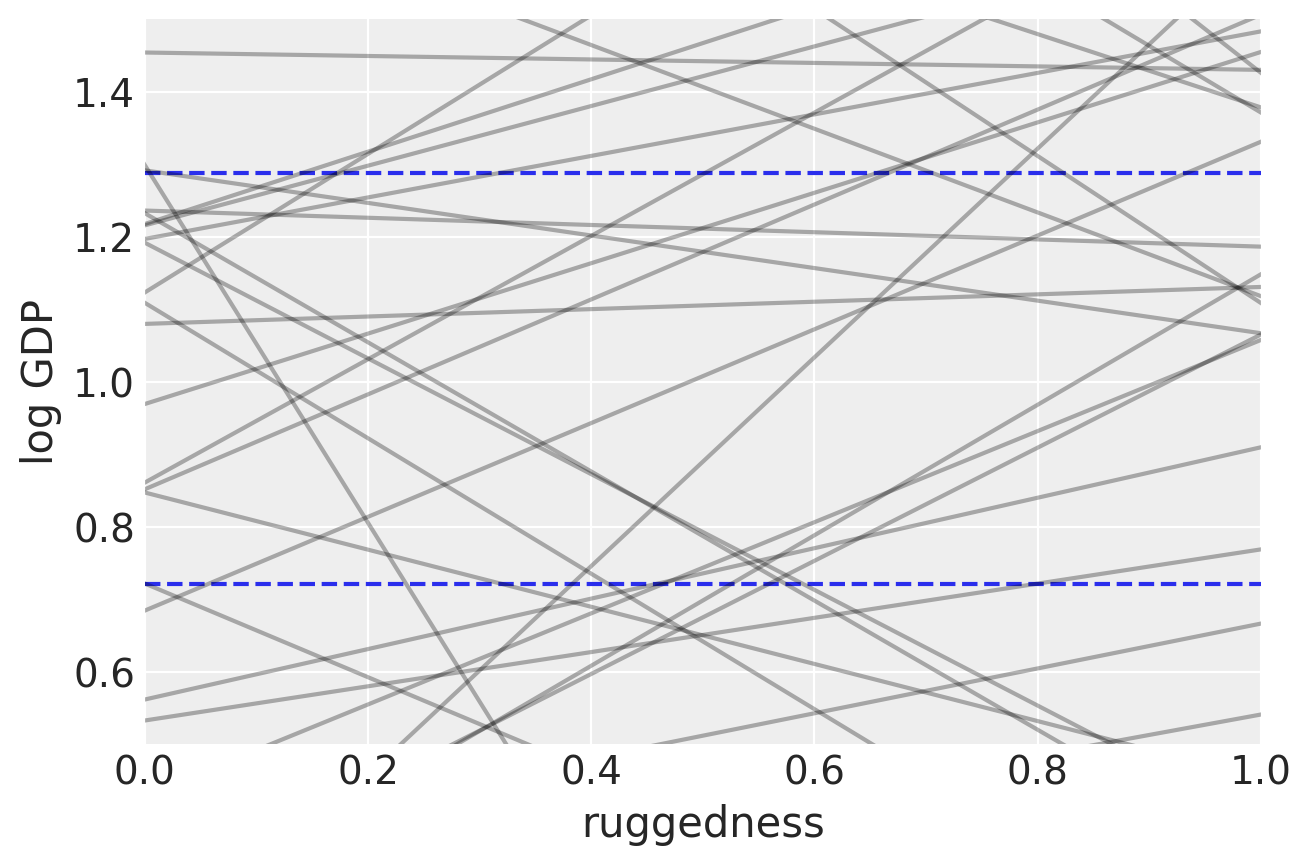

In [12]:
jdc_8_1 = model_8_1(rugged_std=dd["rugged_std"].values)

sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = ds[-1].distribution.loc

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

## Code 8.4

In [13]:
np.sum(np.abs(sample_beta) > 0.6) / sample_beta.shape[0]

0.552

## Code 8.5

In [14]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_1 = model_8_1(rugged_std=dd["rugged_std"].values)

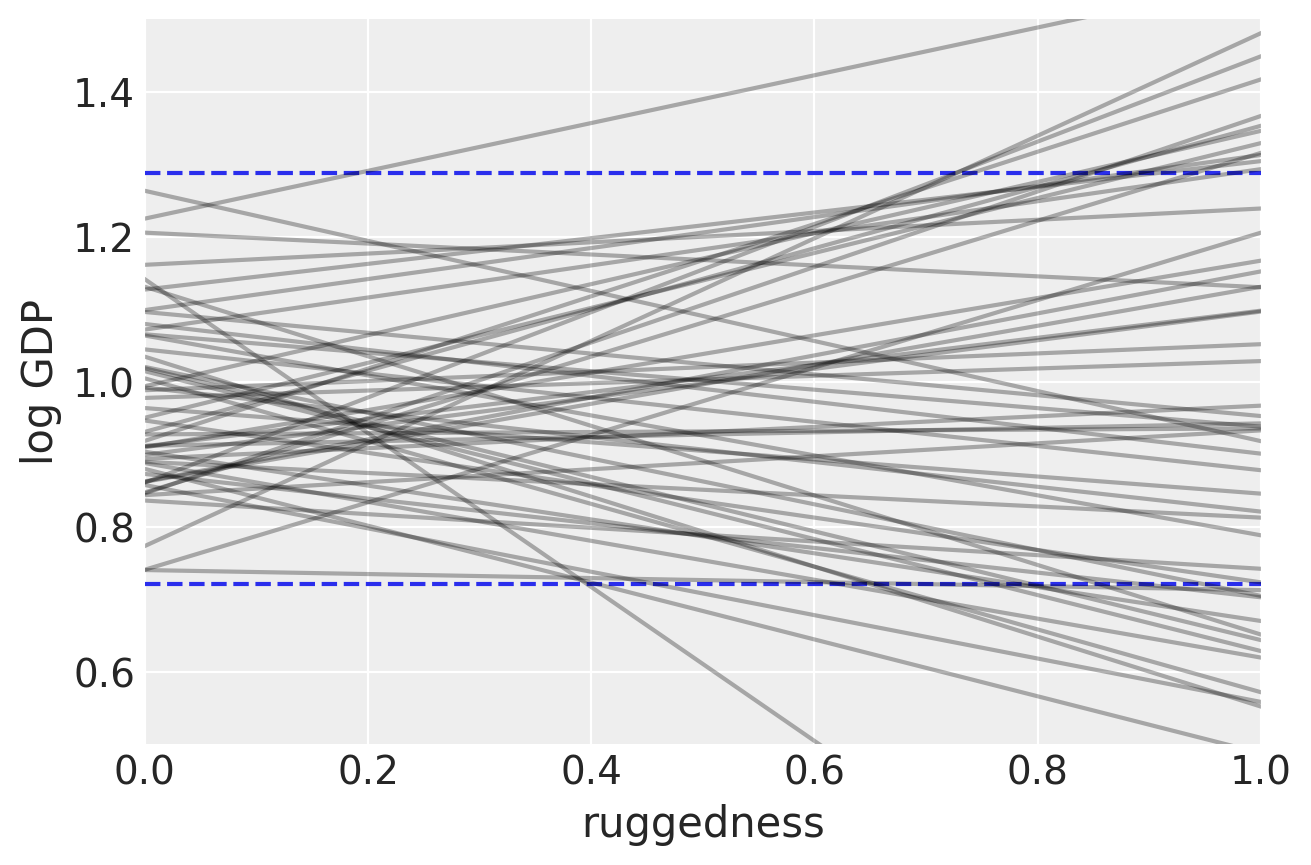

In [15]:
sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = tf.squeeze(ds[-1].distribution.loc)

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

## Code 8.6

In [16]:
NUM_CHAINS_FOR_8_1 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_8_1]),
    tf.zeros([NUM_CHAINS_FOR_8_1]),
    tf.ones([NUM_CHAINS_FOR_8_1]),
]


bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),    
]

trace_8_1 = sample_posterior(jdc_8_1,
                           observed_data=(tf.cast(dd["log_gdp_std"].values, dtype=tf.float32),),
                           params=['alpha', 'beta', 'sigma'],
                           init_state=init_state,
                           bijectors=bijectors)


az.summary(trace_8_1, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.011,0.984,1.017,0.000,0.000,806.0,806.0,793.0,717.0,1.01
beta,0.006,0.052,-0.086,0.080,0.003,0.002,403.0,403.0,402.0,534.0,1.00
sigma,0.138,0.008,0.127,0.151,0.000,0.000,318.0,317.0,325.0,410.0,1.00


## Code 8.7

In [17]:
# make variable to index Africa (0) or not (1)
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

dd["cid"]

2      0
4      1
7      1
8      1
9      1
      ..
229    1
230    1
231    0
232    0
233    0
Name: cid, Length: 170, dtype: int64

## Code 8.8

In [18]:
def model_8_2(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_2 = model_8_2(dd["cid"].values, rugged_std=dd["rugged_std"].values)

In [19]:
init_state = [
    tf.ones([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

trace_8_2 = sample_posterior(
                    jdc_8_2, 
                    observed_data=(tf.cast(dd["log_gdp_std"].values, dtype=tf.float32),),
                    params=['alpha', 'beta', 'sigma'],
                    init_state=init_state,
                    bijectors=bijectors)

In [20]:
az.summary(trace_8_2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.881,0.016,0.859,0.912,0.001,0.000,650.0,649.0,638.0,548.0,1.00
alpha[1],1.050,0.010,1.033,1.063,0.000,0.000,436.0,435.0,446.0,410.0,1.00
beta,-0.049,0.043,-0.110,0.024,0.002,0.001,436.0,436.0,451.0,415.0,1.00
sigma,0.114,0.006,0.104,0.123,0.000,0.000,262.0,262.0,262.0,460.0,1.01


## Code 8.9

In [21]:
def compute_and_store_log_likelihood_for_model_8_1():
    
    sample_alpha = trace_8_1.posterior["alpha"].values
    sample_beta  = trace_8_1.posterior["beta"].values
    sample_sigma = trace_8_1.posterior["sigma"].values
    
    ds, _ = jdc_8_1.sample_distributions(value=[
        tf.cast(sample_alpha, dtype=tf.float32),
        tf.cast(sample_beta, dtype=tf.float32),
        tf.cast(sample_sigma, dtype=tf.float32),
        None
    ])
    
    log_likelihood_8_1 = ds[-1].distribution.log_prob(dd["log_gdp_std"].values).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_1 = trace_8_1.sample_stats
    
    coords = [sample_stats_8_1.coords['chain'], sample_stats_8_1.coords['draw'], np.arange(170)]

    sample_stats_8_1["log_likelihood"] = xr.DataArray(
        log_likelihood_8_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_1()

In [22]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_2():
    
    sample_alpha = trace_8_2.posterior["alpha"].values
    sample_beta  = trace_8_2.posterior["beta"].values
    sample_sigma = trace_8_2.posterior["sigma"].values
    
    ds, _ = jdc_8_2.sample_distributions(value=[
        tf.cast(sample_alpha, dtype=tf.float32),
        tf.cast(sample_beta, dtype=tf.float32),
        tf.cast(sample_sigma, dtype=tf.float32),
        None
    ])
    
    log_likelihood_8_2 = ds[-1].distribution.log_prob(dd["log_gdp_std"].values).numpy() 
    
    # we need to insert this in the sampler_stats
    sample_stats_8_2 = trace_8_2.sample_stats
    
    coords = [sample_stats_8_2.coords['chain'], sample_stats_8_2.coords['draw'], np.arange(170)]

    sample_stats_8_2["log_likelihood"] = xr.DataArray(
        log_likelihood_8_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_2()

In [23]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.2,0,126.534,3.74519,0,0.999999,6.32334,0,False,log
m8.1,1,94.4796,2.5031,32.0541,8.55498e-07,7.21745,7.28355,False,log


## Code 8.10

In [24]:
az.summary(trace_8_2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.881,0.016,0.859,0.912,0.001,0.000,650.0,649.0,638.0,548.0,1.00
alpha[1],1.050,0.010,1.033,1.063,0.000,0.000,436.0,435.0,446.0,410.0,1.00
beta,-0.049,0.043,-0.110,0.024,0.002,0.001,436.0,436.0,451.0,415.0,1.00
sigma,0.114,0.006,0.104,0.123,0.000,0.000,262.0,262.0,262.0,460.0,1.01


## Code 8.11

In [25]:
diff_a = trace_8_2.posterior["alpha"][:,:, 0] - trace_8_2.posterior["alpha"][:,:, 1]

In [26]:
trace_8_2.posterior["diff_a"] = diff_a

az.summary(trace_8_2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.881,0.016,0.859,0.912,0.001,0.000,650.0,649.0,638.0,548.0,1.00
alpha[1],1.050,0.010,1.033,1.063,0.000,0.000,436.0,435.0,446.0,410.0,1.00
beta,-0.049,0.043,-0.110,0.024,0.002,0.001,436.0,436.0,451.0,415.0,1.00
sigma,0.114,0.006,0.104,0.123,0.000,0.000,262.0,262.0,262.0,460.0,1.01
diff_a,-0.168,0.019,-0.194,-0.132,0.001,0.001,541.0,541.0,537.0,512.0,1.01


## Code 8.12

In [27]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = trace_8_2.posterior["alpha"].values[0]
sample_beta  = trace_8_2.posterior["beta"].values[0]
sample_sigma = trace_8_2.posterior["sigma"].values[0]

# compute mu over samples, fixing cid=1
jdc_8_2_test_cid_1 = model_8_2(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_1.sample_distributions(value=[
    tf.cast(sample_alpha, dtype=tf.float32),
    tf.cast(sample_beta, dtype=tf.float32),
    tf.cast(sample_sigma, dtype=tf.float32),
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = np.mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = np.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_2_test_cid_0 = model_8_2(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_0.sample_distributions(value=[
    tf.cast(sample_alpha, dtype=tf.float32),
    tf.cast(sample_beta, dtype=tf.float32),
    tf.cast(sample_sigma, dtype=tf.float32),
    None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = np.mean(mu_Africa, 0)
mu_Africa_ci = np.percentile(mu_Africa, q=(1.5, 98.5), axis=0)

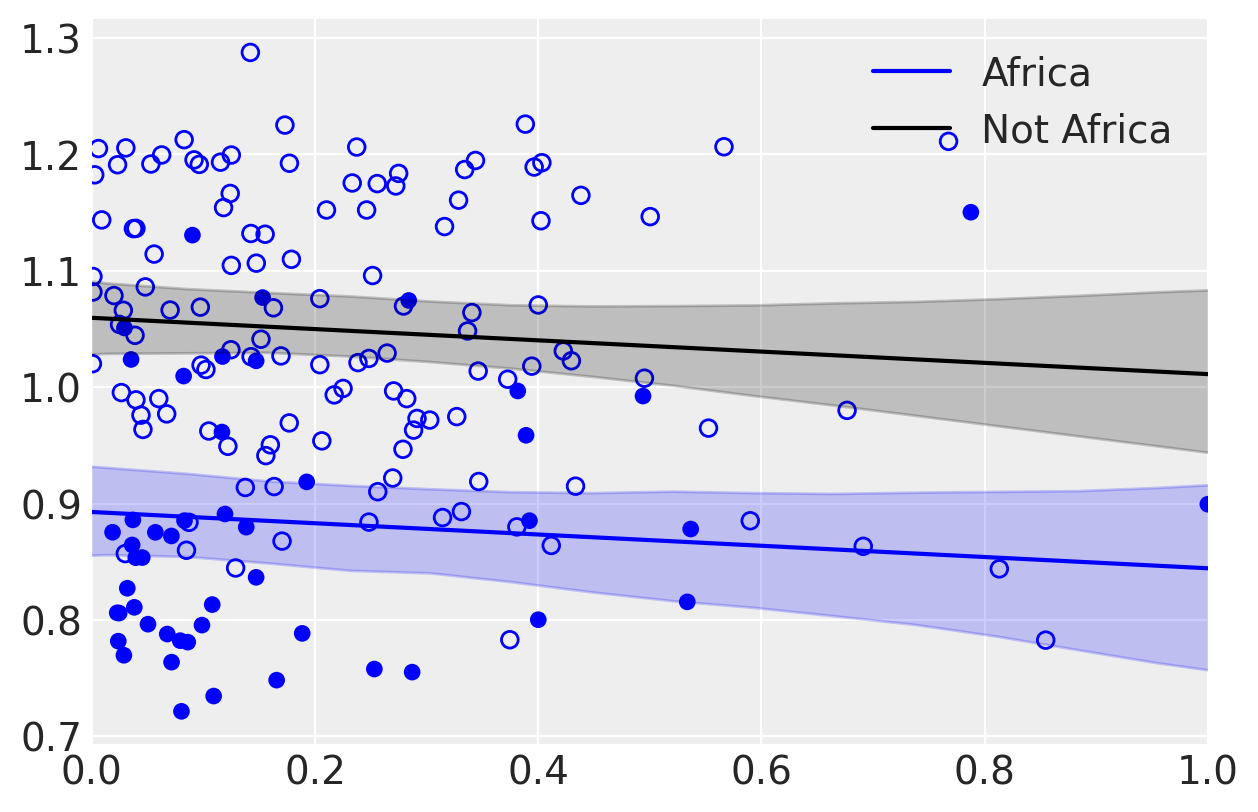

In [28]:
# draw figure 8.4 in the book [note - no code was provided for it in the book]

plt.xlim(0.0, 1.0)
plt.scatter(dd.rugged_std, dd.log_gdp_std, 
            edgecolors=["none" if i == 0 else "b" for i in dd["cid"]],
            facecolors=["none" if i == 1 else "b" for i in dd["cid"]])

# draw MAP line
plt.plot(rugged_seq, mu_Africa_mu, "b", label="Africa")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)

plt.plot(rugged_seq, mu_NotAfrica_mu, "k", label="Not Africa")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)

plt.legend();

## Code 8.13

In [29]:
def model_8_3(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + tf.gather(beta, cid, axis=-1) * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_3 = model_8_3(dd["cid"].values, rugged_std=dd["rugged_std"].values)

In [30]:
init_state = [
    tf.ones([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS, 2]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

trace_8_3 = sample_posterior(
                    jdc_8_3, 
                    observed_data=(tf.cast(dd["log_gdp_std"].values, dtype=tf.float32),),
                    params=['alpha', 'beta', 'sigma'],
                    num_samples=1000,
                    init_state=init_state,
                    bijectors=bijectors)

## Code 8.14

In [31]:
az.summary(trace_8_3, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.887,0.016,0.863,0.911,0.000,0.000,1952.0,1952.0,1964.0,1283.0,1.00
alpha[1],1.051,0.010,1.035,1.067,0.000,0.000,512.0,512.0,518.0,500.0,1.00
beta[0],0.140,0.077,0.022,0.268,0.005,0.004,223.0,223.0,222.0,445.0,1.02
beta[1],-0.143,0.055,-0.221,-0.046,0.002,0.002,619.0,619.0,618.0,852.0,1.00
sigma,0.112,0.006,0.102,0.121,0.000,0.000,469.0,469.0,468.0,808.0,1.00


## Code 8.15

In [32]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_3():
    
    sample_alpha = trace_8_3.posterior["alpha"].values
    sample_beta  = trace_8_3.posterior["beta"].values
    sample_sigma = trace_8_3.posterior["sigma"].values
    
    ds, _ = jdc_8_3.sample_distributions(value=[
        tf.cast(sample_alpha, dtype=tf.float32),
        tf.cast(sample_beta, dtype=tf.float32),
        tf.cast(sample_sigma, dtype=tf.float32),
        None
    ])
    
    log_likelihood_8_3 = ds[-1].distribution.log_prob(dd["log_gdp_std"].values).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_3 = trace_8_3.sample_stats
    
    coords = [sample_stats_8_3.coords['chain'], sample_stats_8_3.coords['draw'], np.arange(170)]

    sample_stats_8_3["log_likelihood"] = xr.DataArray(
        log_likelihood_8_3, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_3()

In [33]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2,
            "m8.3": trace_8_3})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.3,0,129.607,4.96383,0,0.797337,6.63503,0,False,log
m8.2,1,126.534,3.74519,3.0734,0.202663,7.30305,3.29019,False,log
m8.1,2,94.4796,2.5031,35.1275,3.0732e-09,7.21613,7.47886,False,log


## Code 8.16

In [34]:
az.waic(trace_8_3, pointwise=True)

/Users/ksachdeva/Desktop/Dev/projects/myoss/rethinking-tensorflow-probability/env/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 170 log-likelihood matrix

          Estimate       SE
elpd_waic   129.66     7.31
p_waic        4.91        -

There has been a warning during the calculation. Please check the results.

## Code 8.17

In [35]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = trace_8_3.posterior["alpha"].values[0]
sample_beta  = trace_8_3.posterior["beta"].values[0]
sample_sigma = trace_8_3.posterior["sigma"].values[0]

# compute mu over samples, fixing cid=1
jdc_8_3_test_cid_1 = model_8_3(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_1.sample_distributions(value=[
    tf.cast(sample_alpha, dtype=tf.float32),
    tf.cast(sample_beta, dtype=tf.float32),
    tf.cast(sample_sigma, dtype=tf.float32),
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = np.mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = np.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_3_test_cid_0 = model_8_3(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_0.sample_distributions(value=[
    tf.cast(sample_alpha, dtype=tf.float32),
    tf.cast(sample_beta, dtype=tf.float32),
    tf.cast(sample_sigma, dtype=tf.float32),
    None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = np.mean(mu_Africa, 0)
mu_Africa_ci = np.percentile(mu_Africa, q=(1.5, 98.5), axis=0)


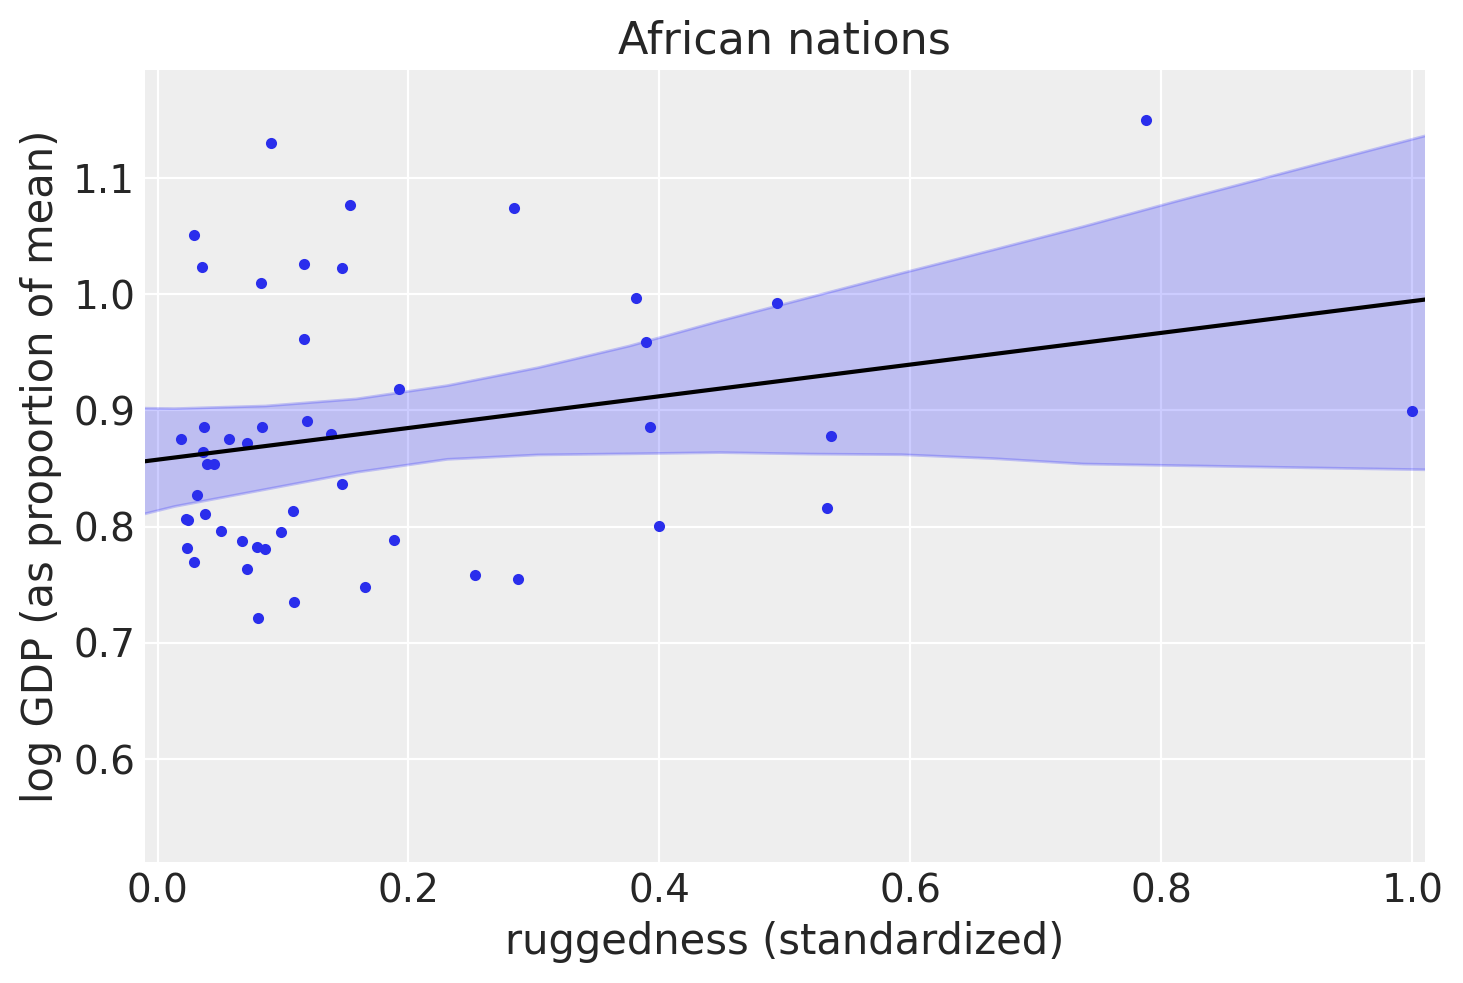

In [36]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_Africa_mu, "k")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)
plt.title("African nations")
plt.show()

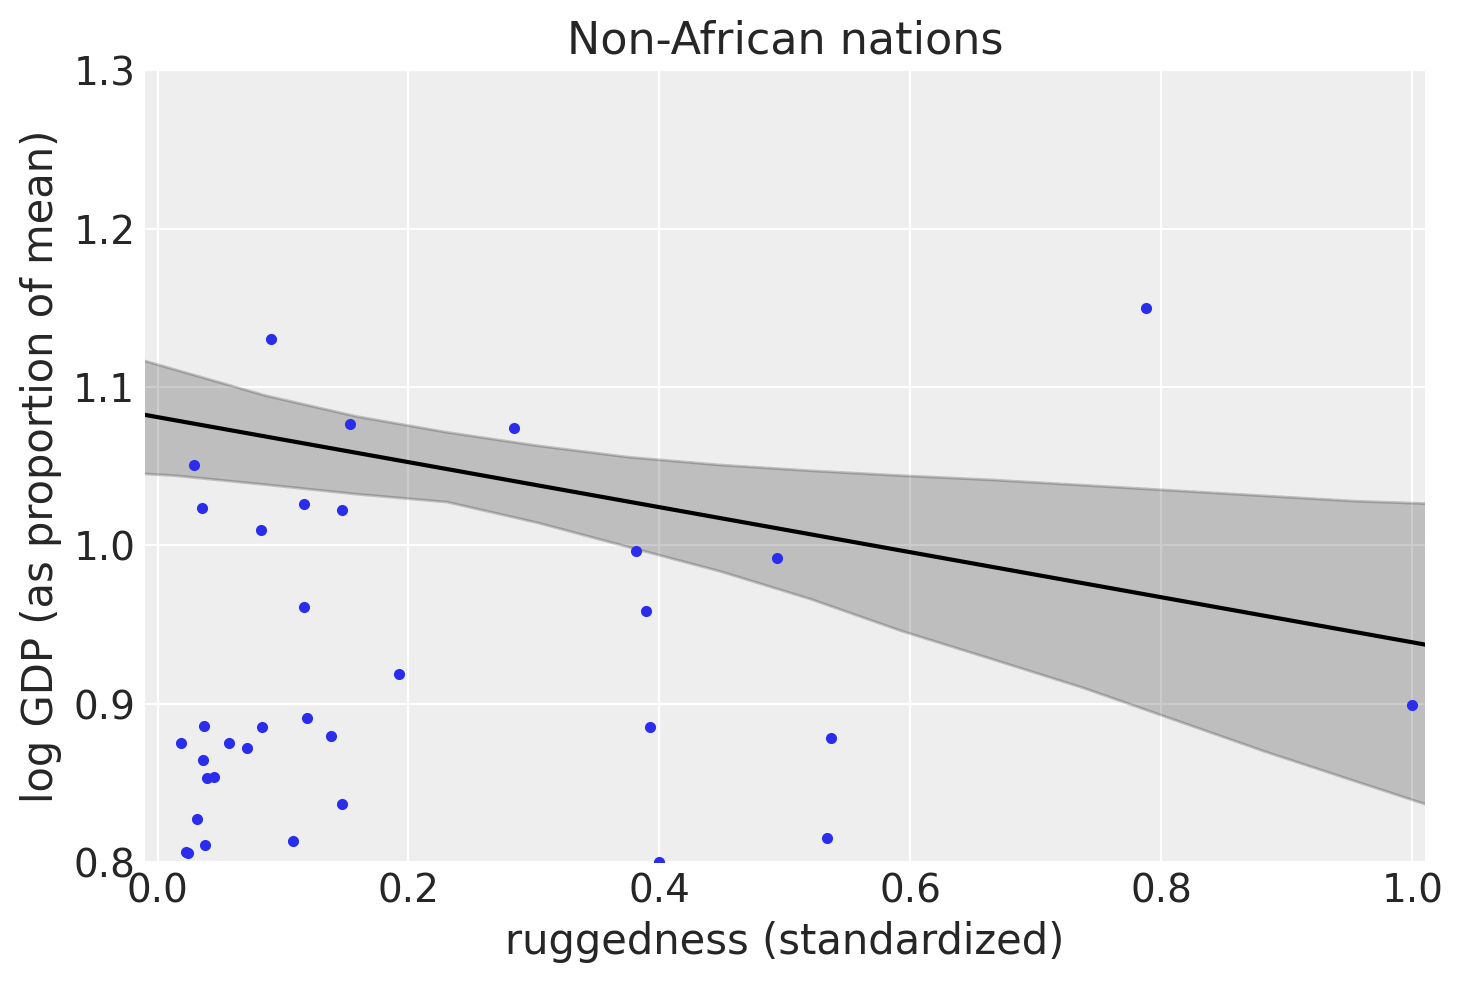

In [37]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylim=(0.8,1.3),
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_NotAfrica_mu, "k")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)
plt.title("Non-African nations")
plt.show()

## Code 8.18

In [38]:
# TODO - draw corresponding graph (Figure 8.6)

rugged_seq = np.linspace(start=-0.2, stop=1.2, num=30)
delta = mu_Africa_mu - mu_NotAfrica_mu

## Code 8.19

In [39]:
d = pd.read_csv(TULIPS_DATASET_PATH, sep=";")
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


## Code 8.20

In [40]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

## Code 8.21

In [41]:
a = tfd.Normal(loc=0.5, scale=1.).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.6093

## Code 8.22

In [42]:
a = tfd.Normal(loc=0.5, scale=0.25).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.0466

## Code 8.23

In [43]:
def model_8_4(water_cent, shade_cent,):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaW[...,tf.newaxis] * water_cent + betaS[...,tf.newaxis] * shade_cent
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_4 = model_8_4(shade_cent=d.shade_cent.values, 
                    water_cent=d.water_cent.values,)

In [44]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

trace_8_4 = sample_posterior(
                    jdc_8_4, 
                    observed_data=(tf.cast(d.blooms_std.values, dtype=tf.float32),),
                    params=['alpha', 'betaW', 'betaS', 'sigma'],
                    num_samples=1000,
                    init_state=init_state,
                    bijectors=bijectors)

## Code 8.24

In [45]:
def model_8_5(water_cent, shade_cent):
    def _generator():
        alpha  = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        betaWS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaWS'), sample_shape=1))
        sigma  = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + \
                betaW[...,tf.newaxis]  * water_cent + \
                betaS[...,tf.newaxis]  * shade_cent + \
                betaWS[...,tf.newaxis] * shade_cent * water_cent
        
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

jdc_8_5 = model_8_5(shade_cent=d.shade_cent.values, 
                    water_cent=d.water_cent.values)

In [46]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

trace_8_5 = sample_posterior(
                    jdc_8_5, 
                    observed_data=(tf.cast(d.blooms_std.values, dtype=tf.float32),),
                    params=['alpha', 'betaW', 'betaS', 'betaWS', 'sigma'],
                    num_samples=1000,
                    init_state=init_state,
                    bijectors=bijectors)

## Code 8.25

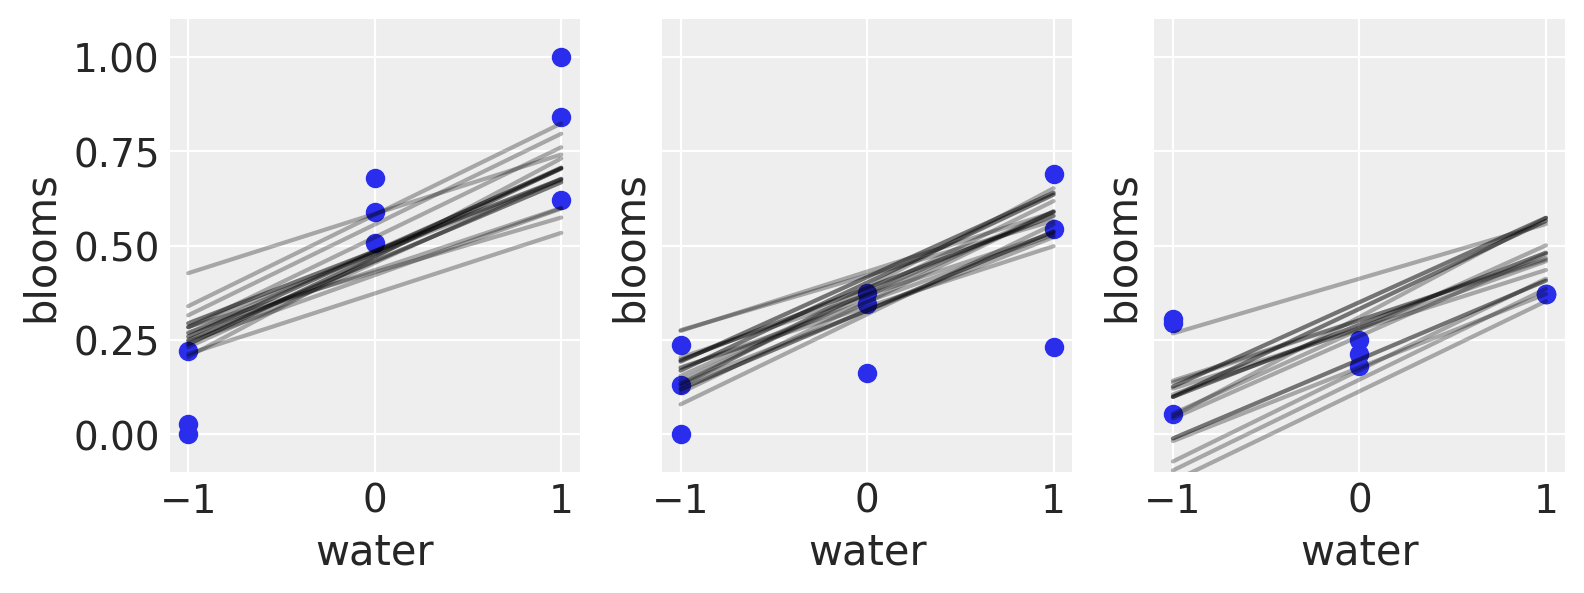

In [47]:
sample_alpha  = trace_8_4.posterior['alpha'].values[0]
sample_betaW  = trace_8_4.posterior['betaW'].values[0]
sample_betaS  = trace_8_4.posterior['betaS'].values[0]    
sample_sigma  = trace_8_4.posterior['sigma'].values[0]

_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)    
    
    jdc_8_4_test = model_8_4(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_4_test.sample_distributions(value=[
        tf.cast(sample_alpha,  dtype=tf.float32),
        tf.cast(sample_betaW,  dtype=tf.float32),        
        tf.cast(sample_betaS,  dtype=tf.float32),        
        tf.cast(sample_sigma,  dtype=tf.float32),
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc)    

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

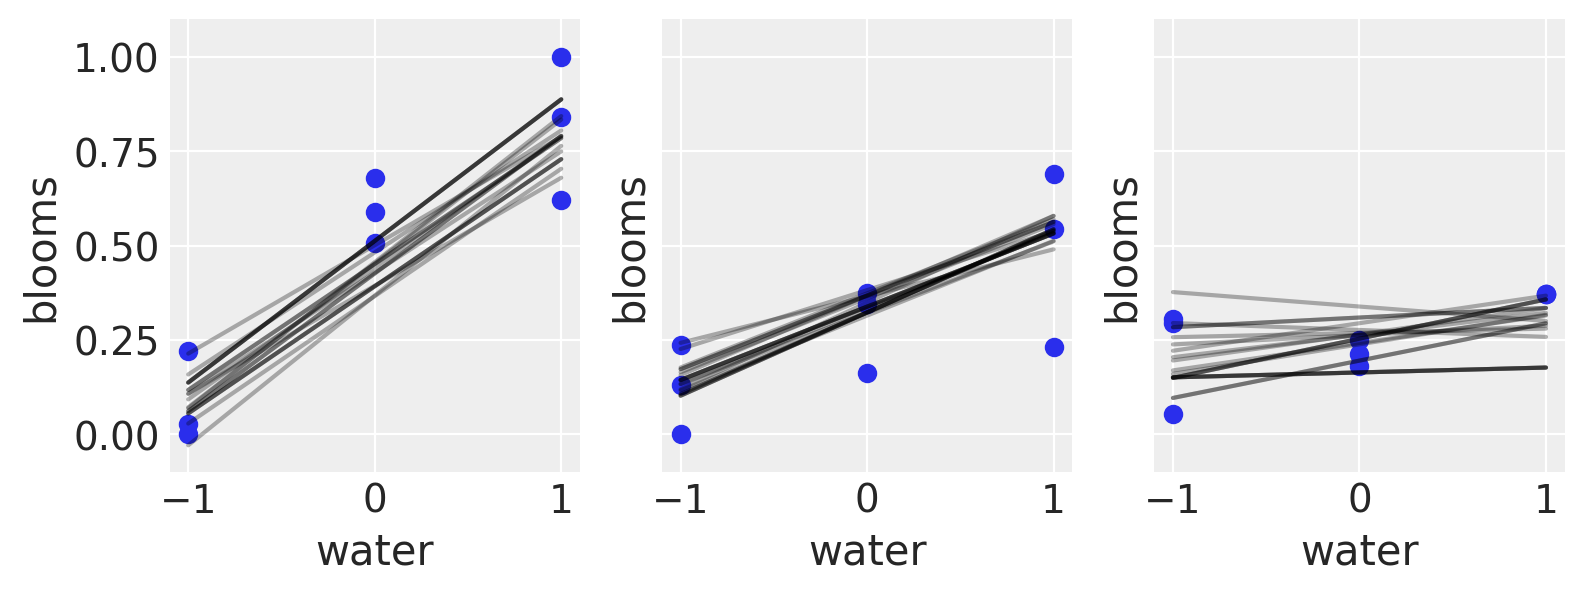

In [48]:
# Code for plotting model 8.5 is not listed in the book but there are corresponding figures so
# draw them here

sample_alpha  = trace_8_5.posterior['alpha'].values[0]
sample_betaW  = trace_8_5.posterior['betaW'].values[0]
sample_betaS  = trace_8_5.posterior['betaS'].values[0]    
sample_betaWS = trace_8_5.posterior['betaWS'].values[0]
sample_sigma  = trace_8_5.posterior['sigma'].values[0]
    
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)
    
    jdc_8_5_test = model_8_5(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_5_test.sample_distributions(value=[
        tf.cast(sample_alpha,  dtype=tf.float32),
        tf.cast(sample_betaW,  dtype=tf.float32),        
        tf.cast(sample_betaS,  dtype=tf.float32),        
        tf.cast(sample_betaWS, dtype=tf.float32),        
        tf.cast(sample_sigma,  dtype=tf.float32),
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc) 

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

## Code 8.26

In [49]:
# prior for 8.5
prior_8_5 = jdc_8_5.sample(1000)